<div class='heading'>
    <div style='float:left;'><h1>CPSC 4300/6300: Applied Data Science</h1></div>
    <img style="float: right; padding-right: 10px; width: 65px" src="https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/images/clemson_paw.png"> </div>


## Homework 5: Regression Modeling to Forecast Bike Sharing Usage, Continued

**Clemson University**<br>
**Fall 2021**<br>
**Instructor(s):** Nina Hubig <br>


---



In [1]:
""" RUN THIS CELL TO GET THE RIGHT FORMATTING """
import requests
from IPython.core.display import HTML
css_file = 'https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/css/cpsc6300.css'
styles = requests.get(css_file).text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

<hr style="height:2pt">

<img src="https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/images/BSS.png">

### Overview 

You are hired by the administrators of the [Capital Bikeshare program](https://www.capitalbikeshare.com) program in Washington D.C., to **help them predict the hourly demand for rental bikes** and **give them suggestions on how to increase their revenue**. Your task is to prepare a short report summarizing your findings and make recommendations.

The predicted hourly demand could be used for planning the number of bikes that need to be available in the system at any given hour of the day. It costs the program money if bike stations are full and bikes cannot be returned, or empty and there are no bikes available. You will use multiple linear regression and polynomial regression and will explore ridge and lasso regression to predict bike usage. The goal is to build a regression model that can predict the total number of bike rentals in a given hour of the day, based on all available information given to you. 

An example of a suggestion to increase revenue might be to offer discounts during certain times of the day either during holidays or non-holidays. Your suggestions will depend on your observations of the seasonality of ridership.

The data for this problem were collected from the Capital Bikeshare program over the course of two years (2011 and 2012).



### Use only the libraries below:

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score

from pandas.plotting import scatter_matrix

### Overview
The initial data set is provided in the file `data/BSS_hour_raw.csv`. You will first add features that will help with the analysis and then separate the data into training and test sets. Each row in this file represents the number of rides by registered users and casual users in a given hour of a specific date. There are 12 attributes in total describing besides the number of users the weather if it is a holiday or not etc: 


- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `season` (1 = winter, 2 = spring, 3 = summer, 4 = fall)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `weekday` (0 through 6, with 0 denoting Sunday)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius, normalized)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius, normalized)
- `hum` (relative humidity, normalized)
- `windspeed` (wind speed, normalized)
- `casual` (number of rides that day made by casual riders, not registered in the system)
- `registered` (number of rides that day made by registered riders)

---

<div class="theme">  Getting Started </div>

**NOTE:** This homework assignment is a continuation of Homework 4. 

Load `BSS_train.csv` and `BSS_test.csv` into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday`, `casual`, and `registered` columns from both the train and the test dataset. 

In [3]:
# Your code here
BSS_train = pd.read_csv("BSS_train.csv")
BSS_test = pd.read_csv("BSS_test.csv")
BSS_test.head()

,dteday,hour,holiday,year,workingday,temp,atemp,hum,windspeed,casual,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,2012-12-30,5,0,1,0,0.26,0.2273,0.48,0.2985,0,...,1,0,0,0,0,0,0,1,0,0
1,2012-04-28,19,0,1,0,0.36,0.3485,0.71,0.1343,29,...,0,0,0,0,0,0,1,0,1,0
2,2012-12-11,12,0,1,1,0.36,0.3182,0.53,0.4478,13,...,1,0,1,0,0,0,0,1,0,0
3,2012-02-10,0,0,1,1,0.28,0.3030,0.65,0.0896,4,...,0,0,0,0,0,1,0,1,0,0
4,2012-07-22,1,0,1,0,0.60,0.5455,0.88,0.1642,31,...,0,0,0,0,0,0,0,1,0,0


In [4]:
BSS_train = BSS_train.drop(['dteday', 'casual', 'registered'], axis=1 )
BSS_test = BSS_test.drop(['dteday', 'casual', 'registered'], axis=1 )
BSS_test.head()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,counts,spring,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,5,0,1,0,0.26,0.2273,0.48,0.2985,2,0,...,1,0,0,0,0,0,0,1,0,0
1,19,0,1,0,0.36,0.3485,0.71,0.1343,139,1,...,0,0,0,0,0,0,1,0,1,0
2,12,0,1,1,0.36,0.3182,0.53,0.4478,226,0,...,1,0,1,0,0,0,0,1,0,0
3,0,0,1,1,0.28,0.3030,0.65,0.0896,43,0,...,0,0,0,0,0,1,0,1,0,0
4,1,0,1,0,0.60,0.5455,0.88,0.1642,130,0,...,0,0,0,0,0,0,0,1,0,0


---

<div class="theme">  Question 3 - Multiple Linear Regression to Predict Hourly Ridership </div>

<div class='exercise'> <b> Question 3.1 </b> </div>

Use statsmodels to fit a multiple linear regression model to the training set using all the useable predictors (nothing that `count` was derived of and no interactions or polynomial terms) to predict `counts`, and report its $R^2$ score on the train and test sets.  Call this set of predictors `X_train`. Reminder that you need to add a constant column when using statsmodels in order to fit the intercept.

In [10]:
# Your code here
# Your code here
xTrain = BSS_train[['hour', 'holiday', 'year', 'workingday', 'temp', 'atemp', 'hum', 
                    'windspeed', 'spring', 'summer', 'fall', 'Feb', 'Mar', 'Apr', 'May', 
                    'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 
                    'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm']]
yTrain = BSS_train['counts']

xTest = BSS_test[['hour', 'holiday', 'year', 'workingday', 'temp', 'atemp', 'hum', 
                    'windspeed', 'spring', 'summer', 'fall', 'Feb', 'Mar', 'Apr', 'May', 
                    'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 
                    'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm']]
yTest = BSS_test['counts']

XTrain = sm.add_constant(xTrain)
XTest = sm.add_constant(xTest)

OLSTrain = sm.OLS(yTrain, XTrain)
OLSModelTrain = OLSTrain.fit()

OLSTest = sm.OLS(yTest, XTest)
OLSModelTest = OLSTest.fit()
  
# printing the summary table
print(OLSModelTrain.summary())
print(OLSModelTest.summary())

                            OLS Regression Results                            
Dep. Variable:                 counts   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     201.9
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        16:04:55   Log-Likelihood:                -55215.
No. Observations:                8689   AIC:                         1.105e+05
Df Residuals:                    8658   BIC:                         1.107e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -30.4075     10.908     -2.788      0.0

<div class='exercise'> <b> Question 3.2 </b> </div>

Examine the estimated coefficients and report which ones are statistically significant at a significance level of 5% (p-value < 0.05). 

In [12]:
# Your code here
OLSModelTest.params

const         -19.322769
hour            7.275559
holiday       -22.591867
year           78.599835
workingday     10.780316
temp          315.539252
atemp          86.583782
hum          -204.329617
windspeed      32.417827
spring         38.903741
summer         26.026052
fall           61.988515
Feb            -8.533254
Mar           -20.286474
Apr           -41.846289
May           -21.707530
Jun           -72.100782
Jul           -89.934393
Aug           -56.785488
Sept           -7.927411
Oct           -12.725609
Nov           -17.960408
Dec            -3.528133
Mon            -3.156096
Tue            -8.424249
Wed             0.828962
Thu            -3.225784
Fri             2.165617
Sat            13.799042
Cloudy          7.853726
Snow          -27.848055
Storm          56.169147
dtype: float64

In [13]:
OLSModelTest.pvalues

const          8.077104e-02
hour          7.306964e-195
holiday        8.218194e-03
year          4.628592e-142
workingday     2.157935e-03
temp           3.276569e-09
atemp          1.184229e-01
hum            1.075350e-91
windspeed      1.855626e-02
spring         3.363728e-05
summer         2.049082e-02
fall           8.624546e-11
Feb            2.633410e-01
Mar            1.856043e-02
Apr            8.931242e-04
May            1.056486e-01
Jun            1.362152e-07
Jul            6.173169e-09
Aug            1.781742e-04
Sept           5.591128e-01
Oct            3.132234e-01
Nov            1.405379e-01
Dec            7.161308e-01
Mon            4.069163e-01
Tue            3.874463e-02
Wed            8.392904e-01
Thu            4.294037e-01
Fri            5.948090e-01
Sat            1.386361e-02
Cloudy         3.375351e-02
Snow           8.792178e-06
Storm          6.892312e-01
dtype: float64

<div class='exercise'> <b> Question 3.3 </b> </div>

You should see some strange estimates for the predictors representing months.  Carefully interpret the `July` coefficient, and explain why this result is likely occurring (be as specific as possible). 

In [22]:
print(OLSModelTest.params['Jul'])
print(OLSModelTest.pvalues['Jul'])

-89.93439309112884
6.173168738732975e-09


*Your answer here*
The null hypothesis: if the coefficient of July is equal to 0. Because obsered pvalue of July is less than significance level => reject hypothesis => it means coefficient of July is different from 0.
Obsered pvalue of July is significantly less than significance level means the probability of coefficient is equal to 0 very small.

<div class='exercise'> <b> Question 3.4 </b> </div>

To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?

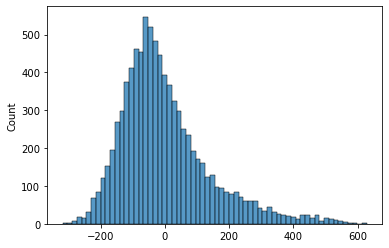

In [49]:
import seaborn as sns
sns.histplot(OLSModelTrain.resid)

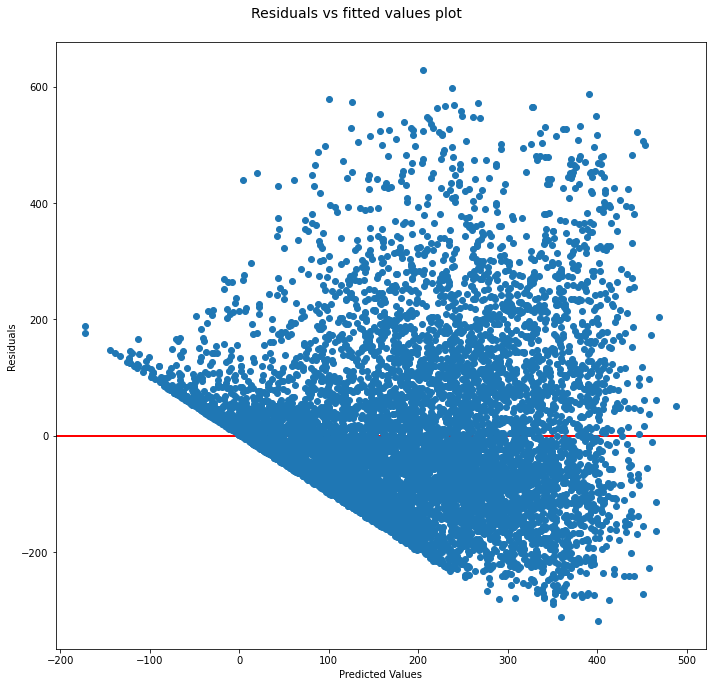

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,10), sharey=True)
fig.suptitle('Residuals vs fitted values plot', fontsize=14)
pred_val = OLSModelTrain.fittedvalues
true_val = BSS_train['counts'].values
residual = true_val - pred_val
ax.scatter(pred_val, residual)
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')
ax.axhline(y=0,c="r", linewidth=2, zorder=0)
fig.tight_layout(rect=[0,0.03,1,0.98])

*Your answer here*
The plots reveal normality about the OLS assumptions.

<div class='exercise'> <b> Question 3.5 </b> </div>

Perhaps we can do better via a model with polynomial terms. Build a dataset `X_train_poly` from your `X_train` data from question 3.1 with added $x^2$ terms for `temp`, `hour`, and `humidity`. Are these polynomial terms important? How does predicted ridership change as each of `temp`, `hour`, and `humidity` increase?

In [27]:
# Your code here
xTrain['temp'].pow(2)
xTrain['hour'].pow(2)
xTrain['hum'].pow(2)
X_train_poly = xTrain
X_train_poly.head()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,spring,summer,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,21,0,1,1,0.24,0.2273,0.60,0.2537,0,0,...,1,0,0,0,1,0,0,1,0,0
1,17,0,0,1,0.62,0.5758,0.83,0.2537,0,0,...,0,0,0,0,1,0,0,0,1,0
2,9,0,1,1,0.76,0.7273,0.66,0.1642,0,1,...,0,0,0,0,1,0,0,0,0,0
3,17,0,1,0,0.62,0.6061,0.22,0.2985,1,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,1,0,0.18,0.1970,0.40,0.1343,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
XTrainPoly = sm.add_constant(X_train_poly)

OutlierOLSTrainPoly = sm.OLS(yTrain, XTrainPoly)
OutlierOLSModelTrainPoly = OutlierOLSTrain.fit()

# printing the summary table
print(OutlierOLSModelTrainPoly.summary())

                            OLS Regression Results                            
Dep. Variable:                 counts   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     201.9
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        22:06:12   Log-Likelihood:                -55215.
No. Observations:                8689   AIC:                         1.105e+05
Df Residuals:                    8658   BIC:                         1.107e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -30.4075     10.908     -2.788      0.0

*Your answer here*

<div class='exercise'> <b> Question 3.6 </b> </div>

You should have received a warning regarding the presence of _multicolinearity_ in the model in 3.1.  Create a new dataset `X_train_drop` by dropping the following predictors from `X_train`:  `workingday` `atemp` `spring` `summer` and `fall` and fit a multiple linear regression model to the variables the remain.  Are the estimates more sensible in this model?  And explain in your own words why multicolinearity can lead to erroneous coefficient values.

In [29]:
# Your code here
xTrain = xTrain.drop(['workingday', 'atemp', 'spring', 'summer'], axis=1 )
X_train_drop = xTrain
XTrainDrop = sm.add_constant(X_train_drop)

OutlierOLSTrainDrop = sm.OLS(yTrain, XTrainPoly)
OutlierOLSModelTrainDrop = OutlierOLSTrain.fit()

# printing the summary table
print(OutlierOLSModelTrainDrop.summary())

                            OLS Regression Results                            
Dep. Variable:                 counts   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     201.9
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        22:06:46   Log-Likelihood:                -55215.
No. Observations:                8689   AIC:                         1.105e+05
Df Residuals:                    8658   BIC:                         1.107e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -30.4075     10.908     -2.788      0.0

*Your answer here*

---

<div class="theme">  Question 4 - Regression Models with Polynomial and Interaction Terms </div>

<div class='exercise'> <b> Question 4.1 </b> </div>

Drop the variables `workingday`, `atemp`, `spring`, `summer`, and `fall` from `BSS_train` (if any of them still remain).

In [30]:
# Your code here
BSS_train =BSS_train.drop(['workingday', 'atemp', 'spring', 'summer', 'fall'],axis=1 )
BSS_train.head()

,hour,holiday,year,temp,hum,windspeed,counts,Feb,Mar,Apr,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,21,0,1,0.24,0.60,0.2537,63,0,0,0,...,1,0,0,0,1,0,0,1,0,0
1,17,0,0,0.62,0.83,0.2537,479,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,9,0,1,0.76,0.66,0.1642,353,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,17,0,1,0.62,0.22,0.2985,411,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,8,0,1,0.18,0.40,0.1343,70,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<div class='exercise'> <b> Question 4.2 </b> </div>

Write a function to standardize a provided subset of columns in your training/validation/test sets. Remember that while you will be scaling all of your data, you must learn the scaling parameters (mean and SD) from only the training set.

Test your code by building a list of all non-binary columns from `X_train` into a dataset called `practice_X_train` and scaling only those columns. Call the result `practice_X_train_scaled`. Display the `.describe()` and verify that you have correctly scaled all columns.

**Hint: employ the provided list of binary columns and use `pd.columns.difference()`**

`binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']`

In [32]:
# Your code here
binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']


def standardize_function(dataframe):
    practice_X_train = dataframe[dataframe.columns.difference(binary_columns)]
    
    df_scaled = pd.DataFrame(StandardScaler().fit_transform(practice_X_train), columns = practice_X_train.columns)
    
    return df_scaled
    
practice_X_train_scaled = standardize_function(xTrain)
practice_X_train_scaled.describe()

,hour,hum,temp,windspeed,year
count,8.689000e+03,8.689000e+03,8.689000e+03,8.689000e+03,8.689000e+03
mean,2.762461e-17,-4.148227e-16,-7.622961e-17,-1.466072e-16,-2.754411e-16
std,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00
min,-1.666359e+00,-3.251974e+00,-2.474192e+00,-1.546636e+00,-1.006813e+00
25%,-8.042663e-01,-7.554808e-01,-8.122824e-01,-6.987336e-01,-1.006813e+00
50%,5.782674e-02,-2.733697e-02,1.867233e-02,2.746035e-02,9.932327e-01
75%,9.199197e-01,8.048274e-01,8.496271e-01,5.118601e-01,9.932327e-01
max,1.638331e+00,1.949053e+00,2.511537e+00,5.355858e+00,9.932327e-01


<div class='exercise'> <b> Question 4.3 </b> </div>

Write a code to augment your a dataset with higher-order features for `temp`, `hum`,`windspeed`, and `hour`. You should include ONLY the pure powers of these columns. So with degree=2 you should produce `temp^2` and `hum^2` but not `temp*hum` or any other two-feature interactions. 

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by producing `practice_X_train_poly`, a training dataset with quadratic and cubic features built from `practice_X_train_scaled`, and printing `practice_X_train_poly`'s column names and `.head()`.

In [34]:
# Your code here
def higher_order(df_scaled, degree, cols):
#   make a copy
    df_copy = df_scaled.copy()
    df_copy = df_scaled[cols]
    #fit transform for the higher test
    for i in range(1, degree):
        transformer = PolynomialFeatures(degree, include_bias=False)
        expanded_df =  transformer.fit_transform(df_copy)
    
        #make into df so can see col vars 
        columns = transformer.get_feature_names(df_copy.columns)
        expanded_df = pd.DataFrame(expanded_df)
        expanded_df.columns = columns
    
        #only do this if poly degree greater than 1
        if degree !=1:
            #get rid of 2 feacture interactions
            degree_cols = [name + "^" + str(i+1) for name in cols]
        
            #new df with only the specific cols 
            degree_df = expanded_df[degree_cols]
        
            expanded_df = pd.concat([df_scaled, degree_df], axis = 1)
        
        return expanded_df
    return
    
    
    
higher_order_feat = ['hum', 'temp', 'windspeed', 'hour']

practice_X_train_poly = higher_order(practice_X_train_scaled, 2, higher_order_feat)
practice_X_train_poly.head()

,hour,hum,temp,windspeed,year,hum^2,temp^2,windspeed^2,hour^2
0,1.350966,-0.131358,-1.331629,0.511860,0.993233,0.017255,1.773236,0.262001,1.825110
1,0.776238,1.064879,0.641888,0.511860,-1.006813,1.133967,0.412021,0.262001,0.602545
2,-0.373220,0.180704,1.368974,-0.214334,0.993233,0.032654,1.874089,0.045939,0.139293
3,0.776238,-2.107748,0.641888,0.875363,0.993233,4.442601,0.412021,0.766260,0.602545
4,-0.516902,-1.171563,-1.643237,-0.456939,0.993233,1.372560,2.700228,0.208794,0.267188


<div class='exercise'> <b> Question 4.4 </b> </div>

Write code to add interaction terms to the model. Specifically, we want interactions between the continuous predictors (`temp`, `hum`,`windspeed`) and the month and weekday dummies (`Feb`, `Mar`...`Dec`, `Mon`, `Tue`, ... `Sat`). That means you SHOULD build `temp*Feb` and `hum*Mon` and so on, but NOT `Feb*Mar` and NOT `Feb*Tue`. The interaction terms should always be a continuous feature times a month dummy or a continuous feature times a weekday dummy.

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by adding interaction terms to `practice_X_train_poly` and show its column names and `.head()`**

In [ ]:
# Your code here

<div class='exercise'> <b> Question 4.5 </b> </div>

Combine all your code so far into a function named `get_design_mats` that takes in `BSS_train`, `BSS_test`, the names of columns for polynomial, the target column, the columns to be dropped and produces computation-ready design matrices `X_train` and `X_test` and responses `y_train` and `y_test`. Your final function should build correct, scaled design matrices with the stated interaction terms and any polynomial degree.

In [ ]:
def get_design_mats(train_df, val_df,  degree, 
                    columns_forpoly=['temp', 'hum','windspeed', 'hour'],
                    target_col='counts', 
                    bad_columns=['counts']):
    """
    :param train_df: The training data
    :param val_df: Your test/validation data
    :param columns_forpoly: List containing the column name for which we want to create 
                            polynomial terms
    :param target_col: The response variable column
    :param bad_columns: The columns you want to drop
    """
    
    # Add code here 
    return x_train,y_train, x_val,y_val


<div class='exercise'> <b> Question 4.6 </b> </div>

For each degree in 1 through 8:

1.  Build the training design matrix and validation design matrix using the function `get_design_mats` with polynomial terms up through the specified degree.

2.  Fit a regression model to the training data.

3.  Report the model's score on the test data.

In [ ]:
"""
    :param train_df: The training data
    :param val_df: Your test/validation data
    :param columns_forpoly: List containing the column name for which we want to create 
                            polynomial terms
    :param target_col: The response variable column
    :param bad_columns: The columns you want to drop
    """

<div class='exercise'> <b> Question 4.7 </b> </div>

Discuss patterns you see in the results from 4.5. Which model would you select, and why?

*Your answer here*

<div class='exercise'> <b> Question 4.8 </b> </div>

Reflect back on the `get_design_mats` function you built. In what way was writing this function useful in your analysis? What issues might you have encountered if you copy/pasted the model-building code instead of tying it together in a function? Does a `get_design_mat` function seem wise in general, or are there better options?

*Your answer here*

---

<div class="theme">  Question 5 - Regularized Models </div>

<div class='exercise'> <b> Question 5.1 </b> </div>

Let's try regularizing our models via ridge regression. Split the training set, `BSS_train`, into an 80-20 train-validation split.  Build a table showing the validation set $R^2$ of polynomial models with degree from 1-8, using your `get_design_mats` function, regularized at the levels $\lambda = (.01, .05, .1,.5, 1, 5, 10, 50, 100)$. Do not perform cross validation at this point, simply report performance on the single validation set. 

In [ ]:
# Your code here

<div class='exercise'> <b> Question 5.2 </b> </div>

Find the best-scoring degree and regularization combination.

In [ ]:
# Your code here

<div class='exercise'> <b> Question 5.3 </b> </div>

It's time to see how well our selected model will do on future data. Use the earlier created test dataset, do any required formatting, and report the best model's $R^2$ score. How does it compare to the validation set score that made us choose this model? Does the test set simply have observations that are more difficult or easier to predict?

In [ ]:
# Your code here

*Your answer here*

<div class='exercise'> <b> Question 5.4 </b> </div>

Build a dataset with polynomial degree 1 and fit an OLS model, a Ridge model, and a Lasso model. Use `RidgeCV` and `LassoCV` to select the best regularization level from among `(.1,.5,1,5,10,50,100)`. 

Note: On the lasso model, you may need to increase `max_iter` (start with 100,000) for the optimization to converge.

In [ ]:
# Your code here

<div class='exercise'> <b> Question 5.5 </b> </div>

Plot histograms of the coefficients found by each of OLS, ridge, and lasso. What trends do you see in the magnitude of the coefficients?

In [ ]:
# Your code here

*Your answer here*

<div class='exercise'> <b> Question 5.6 </b> </div>

The plots above show the overall distribution of coefficient values in each model, but do not show how each model treats individual coefficients. Build a plot which cleanly presents, for each feature in the data, 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso.

**Hint: Bar plots are a possible choice, but you are not required to use them**

**Hint: use `xticks` to label coefficients with their feature names**

In [ ]:
# Your code here

<div class='exercise'> <b> Question 5.7: </b> What trends do you see in the plot above? </div>

*Your answer here*

<div class="theme">  Question 6 - Reflection </div>

These problems are open-ended, and you are not expected to write more than 2-3 sentences. We are interested in seeing that you have thought about these issues; you will be graded on how well you justify your conclusions here, not on what you conclude.

<div class='exercise'> <b> Question 6.1 </b></div>

What are the costs and benefits of applying ridge/lasso regularization to an overfit OLS model, versus setting a specific degree of polynomial or forward selecting polynomial features for the model?

*Your answer here*

<div class='exercise'> <b> Question 6.2 </b></div>

This pset posed a purely predictive goal: forecast ridership as accurately as possible. How important is interpretability in this context? Considering, e.g., your lasso and ridge models from Question 5, how would you react if the models predicted well, but the coefficient values didn't make sense once interpreted?

*Your answer here*

<div class='exercise'> <b> Question 6.3 </b></div>

Reflect back on our original goal of helping BikeShare predict what demand will be like in the week ahead, and thus how many bikes they can bring in for maintenance. In your view, did we accomplish this goal? If yes, which model would you put into production and why? If not, which model came closest, what other analyses might you conduct, and how likely do you think they are to work?

*Your answer here*